# Level 1: Local Frog Discovery Tool benchmark notebook

## Challenge Level 1 Overview


Welcome to the 2022 EY Data Science Challenge! This is the first challenge aimed at beginner/intermediate participants that have little to no experience in data science and programming. For more experienced participants, we recommend undertaking challenge level 2 outlined [here](Model_Level_2.ipynb). If you choose to undertake the first level of the challenge, you will be developing a species distribution model (SDM) for one Australian frog species using only variables from the TerraClimate dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is Litoria fallax, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

<center>
<img src="pictures/Litoria_fallax.jpg" width="500" height="340">
</center>

<br>

**Challenge aim:** to develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |
|2     | Australia, Costa Rica,<br>South Africa | Fine (10m)   | 15 species     | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |

In this notebook, we will demonstrate a basic model workflow that can act as a starting point for the challenge. As specified in the first row of the table above, we will restrict this model to regions in Australia at coarse resolution (4kmx4km), predicting one species against the rest of the 5 specified Australian species using only [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate) predictor variables. In this demonstation, we will be using four features from the TerraClimate dataset, the maximum monthly temperature, the minimum monthly temperature, the mean monthly precipitation, and the mean soil moisture, and will train a logistic regression model with these data. The TerraClimate data is sampled at a monthly temporal resolution, so metrics are calculated over the time dimension to simplify the features. We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 


Most of the functions present in this notebook were adapted from the following notebooks:
- [Training Dataset Summary](../supplementary_notebooks/dataset_summary.ipynb)
- [TerraClimate/Weather](../supplementary_notebooks/TerraClimate.ipynb)

Again, it must be noted that this notebook is just a starting point. We make plenty of assumptions in this notebook that you may not think are best for solving the challenge effectively. You are encouraged to modify these functions, to rewrite them completely, or to try a different approach entirely.


## Load in dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take a while. 

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '..//../'

## Response Variable

Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [2]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

For this demonstration, we will constrain our search to frogs in the Greater Sydney area found between the start of 2015 to the end of 2019. This gives a varied landscape of bushland, plains, rivers, and urban areas. This is done by providing `year_range` and `bbox` parameters to the get_frogs function we defined above.

#### Spatial sampling

While we have restricted our analysis to Greater Sydney for this demonstration,  you are encouraged to explore different areas to assist in creating a SDM that is representative of the habitat of litoria fallax. You could even use the entire training set, but keep in mind that loading in large areas may be quite computationally expensive. We recommend loading data in chunks that are a similar size to the bounding box we defined above.

#### Temporal sampling

Another area that may assist you in developing your SDM is the time dimension of the data. Each occurrence has an "eventDate" attribute, and the terraclimate data is taken monthly. You may want to consider whether more closely matching occurrences to timely data will improve your model. Another idea is to pool the data into larger time chunks like we have done in this notebook. This could involve extending our approach of binning the data in 5 year intervals to include occurrence data for 2010-2015, 2005-2009, etc. Either approach would allow you to utilise more of the training data which could greatly assist your SDM training.

### Addressing bias

Below we define some functions to assist in plotting the frog data. This will assist us in identifying two main areas of bias. We then use these functions to plot the frog species distributions of each country. A more detailed exploration of the training dataset for this challenge can be found in the [dataset summary notebook](supplementary_notebooks/dataset_summary.ipynb).

## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. For a more in-depth look at the TerraClimate dataset and how to query it, see the [TerraClimate supplementary notebook](./supplementary_notebooks/TerraClimate.ipynb)

### Accessing the TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from four assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).


In [6]:
def get_terraclimate_all(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Returns terraclimate data.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').compute()
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        data = data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return data

def get_terraclimate_months(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month."""
    ds = get_terraclimate_all(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    ds_month = [ds.groupby('time.month').max(dim='time'), 
                ds.groupby('time.month').min(dim='time'),
                ds.groupby('time.month').mean(dim='time'),
                ds.groupby('time.month').std(dim='time')]    
    return ds_month

def get_terraclimate(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month and make each month/asset a new variable."""
    ds_list = get_terraclimate_months(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    # hard code in labels for quantities. order is abritrary from get_terraclimate_months
    quantities = ['max','min','mean','std']

        # sets_list is a list of lists of datasets, each dataset has data for each metric/quantity pair
        # I need to unpack it twice. 
    sets_list = []
    for count, ds in enumerate(ds_list):
        sets = [
            ds.sel(month=month
                ).rename(
            {var: ' '.join((str(month), var, quantities[count])) for var in list(ds.keys())}
        ).drop_vars('month')
        for month in ds.month.values
        ]
        sets_list.append(sets)
    ds = xr.merge(
            # unpack each list in sets_list and merge into a larger dataset
        [xr.merge(sets_list[i]) for i in range(len(sets_list))]
            # merge these larger datasets into a dataset and
            # convert it into a data array, and rename the variable to band
        ).to_array().rename(variable='band')   
    return ds




In [4]:
bboxs = [(144.8,-38.5,145.8,-37.5),
(150.7,-33.5,151.7,-32.5),
(152.6,-29.0,153.6,-28.0),
(145.0,-17.7,146.0,-16.7),
(115.7,-32.5,116.7,-31.5)]

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

In [7]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.mean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    },
    'std':{
        'fn':np.std,
        'params':{}
    },
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=[#'tmax_min',
          'tmax_max',
          'tmax_mean',
          'tmin_max',
          'tmin_mean',
          'ppt_mean',
          'ppt_std', 
          'soil_mean',
         'soil_max']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

# Load in data

arrays=[]
for bbox in bboxs:
    weather_data = get_terraclimate(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims)
    arrays.append(weather_data)

Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image


In [14]:
frogs_all_bboxs = []
for bbox in bboxs:
    all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2021), bbox=bbox)
    frogs_all_bboxs.append(all_frog_data)

In [15]:
grid_size = 24
target_species = 'Litoria Fallax'
for bbox_num, all_frog_data in enumerate(frogs_all_bboxs):
    all_frog_data = (
        all_frog_data
        # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
        # as well as a key for joining (later)
        .assign(
            occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
        )
    )
    all_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
    uniform_frog_data = pd.DataFrame()
    for i in range(grid_size):
        for j in range(grid_size):
            min_lon, min_lat, max_lon, max_lat = bboxs[bbox_num]
            target_frogs_in_pixel = all_frog_data.loc[
                (all_frog_data['decimalLatitude'] > min_lat + j/grid_size) & 
                (all_frog_data['decimalLatitude'] <= min_lat + (j+1)/grid_size) &
                (all_frog_data['decimalLongitude'] > min_lon + i/grid_size) &
                (all_frog_data['decimalLongitude'] <= min_lon + (i+1)/grid_size)
            ]
                #print((min_lat,min_lat + (j+1)/grid_size,min_lon, 
                #       min_lon + (i+1)/grid_size, len(target_frogs_in_pixel)))
            if len(target_frogs_in_pixel) == 0:
                # there are no target frogs here 
                # add fake 0
                added_zero = {"decimalLongitude":min_lon + (i+0.5)/grid_size,
                              'decimalLatitude':min_lat + (j+0.5)/grid_size,
                              "occurrenceStatus":0}

                uniform_frog_data=uniform_frog_data.append(added_zero, ignore_index=True)
            if len(target_frogs_in_pixel) > 0:
                # there are frogs here
                # put one frog
                added_frog = {"decimalLongitude":min_lon + (i+0.5)/grid_size,
                              'decimalLatitude':min_lat + (j+0.5)/grid_size,
                              "occurrenceStatus":1}

                uniform_frog_data=uniform_frog_data.append(added_frog, ignore_index=True)
    uniform_frog_data = (
        uniform_frog_data
        # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
        # as well as a key for joining (later)
        .assign(key=lambda x: x.index)
    )
    frogs_all_bboxs[bbox_num] =uniform_frog_data
    

In [16]:
for i in range(len(frogs_all_bboxs)):
    print(i, frogs_all_bboxs[i]['occurrenceStatus'].sum())

0 40.0
1 213.0
2 205.0
3 84.0
4 0.0


In [54]:
target_species = 'Litoria Fallax'
for i in range(len(frogs_all_bboxs)):
    frogs_all_bboxs[i] = (
        frogs_all_bboxs[i]
        # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
        # as well as a key for joining (later)
        .assign(
            occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
        )
        .assign(key=lambda x: x.index)
    )
    

In [17]:
for i in range(len(frogs_all_bboxs)):
    print(frogs_all_bboxs[i]["occurrenceStatus"].value_counts())

0.0    536
1.0     40
Name: occurrenceStatus, dtype: int64
0.0    363
1.0    213
Name: occurrenceStatus, dtype: int64
0.0    371
1.0    205
Name: occurrenceStatus, dtype: int64
0.0    492
1.0     84
Name: occurrenceStatus, dtype: int64
0.0    576
Name: occurrenceStatus, dtype: int64


In [18]:
all_all_frogs = pd.concat(frogs_all_bboxs)

In [19]:
all_all_frogs.tail()

,decimalLongitude,decimalLatitude,occurrenceStatus,key
571,116.679167,-31.687500,0.0,571
572,116.679167,-31.645833,0.0,572
573,116.679167,-31.604167,0.0,573
574,116.679167,-31.562500,0.0,574
575,116.679167,-31.520833,0.0,575


In [95]:
bboxs

[(144.8, -38.5, 145.8, -37.5),
 (150.7, -33.5, 151.7, -32.5),
 (152.6, -29.0, 153.6, -28.0),
 (145.0, -17.7, 146.0, -16.7),
 (115.7, -32.5, 116.7, -31.5)]

# Options for downsampling frogs
1. leave it as is, no downsampling
1. take out randomly to make target match non-target
1. take out randomly to make each species equal
1. take out systmatically trying to leave frogs evenly distributed. eg, take out nearest neighbors?

## HERE I choose option 2, take out rnadomy to make number of target frogs == number of non-target frogs

### Visualising the TerraClimate Data

The spatial distribution of the four variables are displayed below.

IndexError: list index out of range

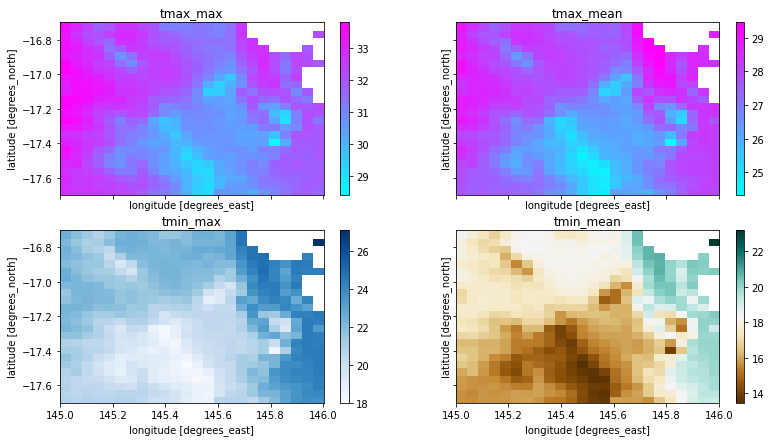

In [59]:
nrow = 2
ncol = 2
for j in range(len(arrays)):
    fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

    bands = arrays[3].band.values
    #filt = frog_data.occurrenceStatus == 1
    cmaps = ["cool", "cool", "Blues", "BrBG"]

    for i in range(len(bands)):
        xr.plot.imshow(arrays[3][i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
        ax[i//ncol, i%ncol].set_title(bands[i])
        #ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
        #                            color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

    fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
    fig.legend(loc=(0.85, 0.933))

In [ ]:
bboxs[4]

### Feature engineering

The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model you decide to train, some of the variables might require normalisation, standardisation, or transformation. For now, we will proceed with the variables as they come.

In [ ]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [20]:
def join_frogs(frog_data, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frog_data.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )

In [21]:
all_pairs = []
for i in range(len(frogs_all_bboxs)):
    model_data = join_frogs(frogs_all_bboxs[i], arrays[i])
    all_pairs.append(model_data)

In [97]:
model_data = pd.concat(all_pairs)
model_data

,decimalLongitude,decimalLatitude,occurrenceStatus,key,1 ppt max,1 ppt mean,1 ppt min,1 ppt std,1 soil max,1 soil mean,...,9 soil min,9 soil std,9 tmax max,9 tmax mean,9 tmax min,9 tmax std,9 tmin max,9 tmin mean,9 tmin min,9 tmin std
0,144.820833,-38.479167,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,144.820833,-38.437500,0.0,1,46.0,33.599998,8.0,13.879481,22.0,15.8,...,30.0,33.109516,16.200005,15.780002,15.099998,0.449001,9.300003,8.180002,7.599998,0.594644
2,144.820833,-38.395833,0.0,2,47.0,34.400002,8.0,14.249210,22.0,15.2,...,28.0,34.035275,16.300003,15.840001,15.099998,0.496388,9.099998,8.020001,7.400002,0.584464
3,144.820833,-38.354167,0.0,3,47.0,34.200001,8.0,14.246404,22.0,15.0,...,26.0,34.452286,16.300003,15.880002,15.200005,0.448998,9.200005,8.060002,7.400002,0.615143
4,144.820833,-38.312500,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,116.679167,-31.687500,0.0,571,43.0,19.000000,0.0,17.944359,7.0,6.4,...,11.0,2.727636,21.500000,20.220001,18.200005,1.132076,7.599998,6.200002,4.200005,1.147169
572,116.679167,-31.645833,0.0,572,41.0,18.000000,0.0,17.064583,7.0,6.0,...,9.0,3.249615,21.900002,20.680002,18.700005,1.107067,8.099998,6.640001,4.599998,1.184230
573,116.679167,-31.604167,0.0,573,42.0,18.400000,0.0,17.533968,7.0,6.0,...,9.0,3.249615,21.900002,20.620001,18.599998,1.132079,8.000000,6.560002,4.599998,1.149957
574,116.679167,-31.562500,0.0,574,43.0,18.600000,0.0,17.805616,7.0,5.8,...,9.0,3.006659,21.800003,20.580002,18.599998,1.107070,8.099998,6.640001,4.599998,1.184230


In [82]:
target_species_frog_data = model_data[model_data.occurrenceStatus == 1]
frog_data = (
    model_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
model_data = frog_data

In [ ]:
model_data

## Model Building

### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [23]:
from sklearn.neural_network import MLPClassifier

In [46]:
#full_model = LogisticRegression()
#model_data_noNans = model_data.dropna()
model_data_dropped = (
    model_data
    .drop(['decimalLatitude', 'decimalLongitude'], 1))
model_data_dropped = model_data_dropped.dropna()
X = (
    model_data_dropped
    .drop(['occurrenceStatus','key'], 1)
)
#X_no_Nans = X.dropna()
#X = X_no_Nans
y = model_data_dropped.occurrenceStatus.astype(int)
#y = y.dropna()
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
y=y.reset_index(drop=True)
X_scaled = scaler.transform(X)
X_scaled_labeled = pd.DataFrame(X_scaled)
X_scaled_labeled = X_scaled_labeled.set_axis(X.columns, axis='columns')
#full_model.fit(X_scaled_labeled, y)
clf_no_DS = MLPClassifier().fit(X_scaled_labeled, y)

In [98]:
model_data.value_counts('occurrenceStatus')

occurrenceStatus
0.0    2338
1.0     542
dtype: int64

In [104]:
target_species_frog_data = model_data[model_data.occurrenceStatus == 1]
frog_data = (
    model_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        int(len(target_species_frog_data)*1.5), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)


In [100]:
frog_data

,decimalLongitude,decimalLatitude,occurrenceStatus,key,1 ppt max,1 ppt mean,1 ppt min,1 ppt std,1 soil max,1 soil mean,...,9 soil min,9 soil std,9 tmax max,9 tmax mean,9 tmax min,9 tmax std,9 tmin max,9 tmin mean,9 tmin min,9 tmin std
0,145.145833,-17.262500,0.0,0,421.0,233.199997,116.0,122.708435,274.0,110.800003,...,27.0,11.074294,28.599998,27.560001,25.500000,1.081851,16.400002,14.460002,12.700005,1.187602
1,150.929167,-32.854167,0.0,1,305.0,120.800003,51.0,98.615211,109.0,32.799999,...,6.0,32.590797,23.099998,20.980001,20.099998,1.094348,8.400002,6.700002,6.000000,0.894428
2,115.804167,-32.062500,0.0,2,29.0,14.200000,0.0,12.106196,32.0,29.200001,...,49.0,36.707493,21.599998,20.140001,18.200005,1.105620,11.000000,9.980001,8.099998,1.022547
3,145.654167,-37.729167,0.0,3,89.0,63.200001,19.0,25.771301,144.0,93.400002,...,196.0,0.000000,13.700005,13.120001,12.300003,0.594643,5.000000,3.640000,2.900002,0.714423
4,115.804167,-31.895833,0.0,4,33.0,16.000000,0.0,13.928389,29.0,25.600000,...,40.0,33.823071,22.000000,20.520000,18.599998,1.108874,11.099998,10.140001,8.300003,0.997195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,145.854167,-17.595833,1.0,1621,858.0,440.200012,168.0,263.289490,443.0,393.799988,...,266.0,53.083332,27.900002,27.000000,25.300003,0.898888,18.700005,16.720003,15.300003,1.121428
1622,145.854167,-17.137500,1.0,1622,870.0,395.399994,169.0,267.945953,427.0,304.799988,...,140.0,33.326267,28.400002,27.700001,26.400002,0.698570,19.700005,17.960003,16.900002,0.954150
1623,145.895833,-17.554167,1.0,1623,1025.0,527.799988,204.0,314.208466,439.0,410.200012,...,313.0,46.084270,28.099998,27.240002,25.599998,0.868563,19.300003,17.320002,15.900002,1.121428
1624,145.937500,-17.429167,1.0,1624,1038.0,524.599976,210.0,317.210083,434.0,401.600006,...,303.0,47.402111,28.099998,27.280003,25.700005,0.842376,19.700005,17.740002,16.400002,1.096541


In [105]:
model_data_dropped = frog_data.dropna()
X = (
    model_data_dropped
    .drop(['occurrenceStatus','key','decimalLongitude','decimalLatitude'], 1)
)
#X_no_Nans = X.dropna()
#X = X_no_Nans
y = model_data_dropped.occurrenceStatus.astype(int)
#y = y.dropna()
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
y=y.reset_index(drop=True)
X_scaled = scaler.transform(X)
X_scaled_labeled = pd.DataFrame(X_scaled)
X_scaled_labeled = X_scaled_labeled.set_axis(X.columns, axis='columns')
#full_model.fit(X_scaled_labeled, y)
clf_DS = MLPClassifier().fit(X_scaled_labeled, y)

In [64]:
in_samp_predicts = clf_DS.predict(X_scaled_labeled)

In [48]:
clf_no_DS.score(X_scaled_labeled,y)

0.8887256702166728

In [90]:
clf_DS.score(X_scaled_labeled,y)

0.876555023923445

In [49]:
full_model = clf_no_DS

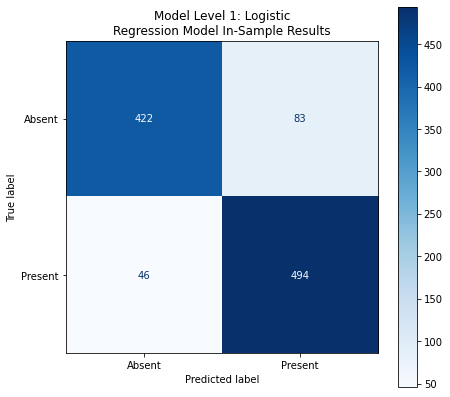

In [91]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf_DS, X_scaled_labeled, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

In [51]:
full_model = clf_no_DS

In [ ]:
y

### Model Prediction

#### Predict Training Set

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To obtain the predictions for our training set, we simply use the `predict` method on our trained model. We will evaluate these predictions in the evaluation section of this notebook.

In [39]:
real_frogs_all_bboxs = []
for bbox in bboxs:
    all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2021), bbox=bbox)
    real_frogs_all_bboxs.append(all_frog_data)

In [40]:
target_species = 'Litoria Fallax'
for i in range(len(real_frogs_all_bboxs)):
    real_frogs_all_bboxs[i] = (
        real_frogs_all_bboxs[i]
        # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
        # as well as a key for joining (later)
        .assign(
            occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
        )
        .assign(key=lambda x: x.index)
    )
    
real_pairs = []
for i in range(len(real_frogs_all_bboxs)):
    real_model_data = join_frogs(real_frogs_all_bboxs[i], arrays[i])
    real_pairs.append(real_model_data)

In [41]:
all_real_frogs = pd.concat(real_frogs_all_bboxs)

In [42]:
model_data_test = pd.concat(real_pairs)
model_data_test

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,...,9 soil min,9 soil std,9 tmax max,9 tmax mean,9 tmax min,9 tmax std,9 tmin max,9 tmin mean,9 tmin min,9 tmin std
0,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0,2780,...,58.0,64.724030,17.099998,16.540001,15.800003,0.535163,8.400002,7.180002,6.500000,0.652381
1,3384896595,2021-10-07 07:58:39,Australia,Australia,Victoria,-38.030947,145.432053,Crinia Signifera,0,3279,...,133.0,58.321865,16.599998,16.080000,15.400002,0.526877,7.800003,6.600001,5.900002,0.648074
2,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0,4737,...,98.0,69.232941,17.099998,16.620001,16.099998,0.396988,8.000000,6.720000,6.099998,0.661514
3,3463456499,2019-07-30 00:00:00,Australia,Australia,Victoria,-37.807553,145.263607,Crinia Signifera,0,4780,...,80.0,42.371689,17.099998,16.480000,15.599998,0.620967,7.800003,6.560002,5.800003,0.671118
4,3463456516,2020-08-23 00:00:00,Australia,Australia,Victoria,-37.991842,145.118825,Crinia Signifera,0,4787,...,18.0,37.986313,17.800003,17.160002,16.400002,0.595316,9.000000,7.740001,7.000000,0.674092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6709,1640023933,2017-09-09 16:00:00,Australia,Australia,Western Australia,-31.933553,115.909463,Crinia Glauerti,0,95809,...,46.0,33.434116,21.900002,20.440002,18.500000,1.116423,11.000000,9.880000,8.000000,1.038075
6710,1632969821,2016-04-13 08:04:00,Australia,Australia,Western Australia,-32.014768,115.895289,Crinia Glauerti,0,95839,...,51.0,35.892059,21.700005,20.300001,18.400002,1.086279,10.800003,9.740001,7.900002,1.003195
6711,3381434234,2017-11-18 00:00:00,Australia,Australia,Western Australia,-32.242003,115.834441,Crinia Signifera,0,149899,...,70.0,25.435408,21.400002,19.980001,18.099998,1.077777,10.500000,9.420001,7.599998,0.990758
6712,3381443465,2017-11-17 00:00:00,Australia,Australia,Western Australia,-31.775465,115.742627,Crinia Signifera,0,151331,...,36.0,29.702524,22.099998,20.520000,18.599998,1.130310,11.099998,10.259999,8.400002,1.001198


In [52]:
model_data_test_noNans = model_data_test.dropna()

X_test = (
    model_data_test_noNans
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1)
)
y_test = model_data_test_noNans.occurrenceStatus.astype(int)

y_test=y_test.reset_index(drop=True)
X_test_scaled = scaler.transform(X_test)
X_test_scaled_labeled = pd.DataFrame(X_test_scaled)
X_test_scaled_labeled = X_test_scaled_labeled.set_axis(X_test.columns, axis='columns')

In [54]:
#predictions = full_model.predict(X)
predictions = clf_no_DS.predict(X_test_scaled_labeled)

In [55]:
clf_no_DS.score(X_test_scaled_labeled,y_test)

0.6935710275126333

In [92]:
clf_DS.score(X_test_scaled_labeled,y_test)

0.6325098259404829

In [107]:
clf_DS.score(X_test_scaled_labeled,y_test)

0.6679884896125772

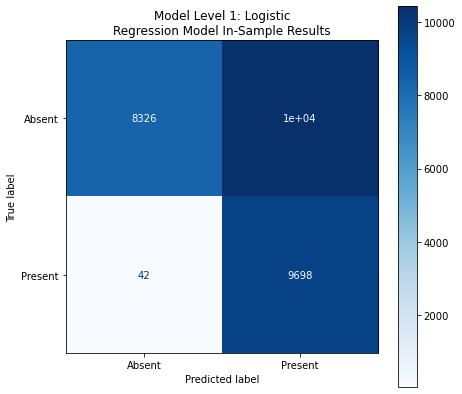

In [93]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf_DS, X_test_scaled_labeled, y_test, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

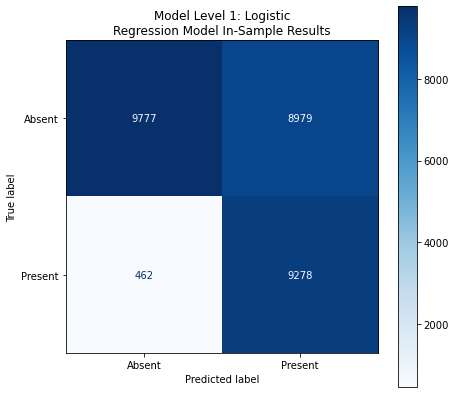

In [102]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf_DS, X_test_scaled_labeled, y_test, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

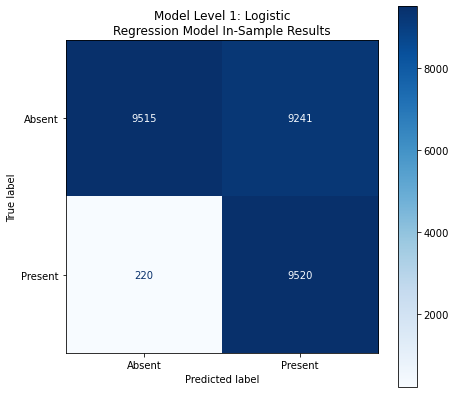

In [106]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf_DS, X_test_scaled_labeled, y_test, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

In [116]:
target_species_frog_data = model_data[model_data.occurrenceStatus == 1]
frog_data = (
    model_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        int(len(target_species_frog_data)*4), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)


In [117]:
model_data_dropped = frog_data.dropna()
X = (
    model_data_dropped
    .drop(['occurrenceStatus','key','decimalLongitude','decimalLatitude'], 1)
)
#X_no_Nans = X.dropna()
#X = X_no_Nans
y = model_data_dropped.occurrenceStatus.astype(int)
#y = y.dropna()
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
y=y.reset_index(drop=True)
X_scaled = scaler.transform(X)
X_scaled_labeled = pd.DataFrame(X_scaled)
X_scaled_labeled = X_scaled_labeled.set_axis(X.columns, axis='columns')
#full_model.fit(X_scaled_labeled, y)
clf_DS = MLPClassifier().fit(X_scaled_labeled, y)

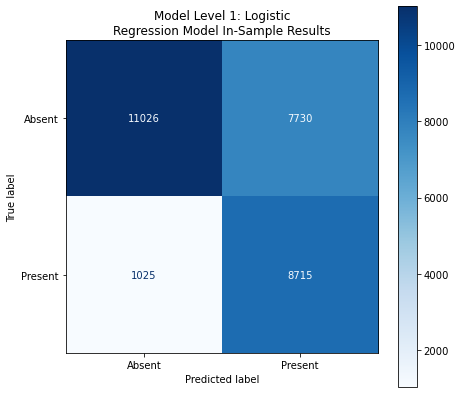

In [118]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf_DS, X_test_scaled_labeled, y_test, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

In [119]:
clf_DS.score(X_test_scaled_labeled,y_test)

0.6927638966872544

#### Predict Entire Region

For a species distribution model to be effective, it must also be capable of performing predictions over the entire region, not just the points in our training set. To do this, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel in the region. We will visualise these predictions in a heatmap in the results section of this notebook.

This function will be used later to predict the test regions for the challenge. 


In [150]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    ## preform preprocessing ###
    scaled_data = scaler.transform(predictor_image.data)
    predictor_image.data = scaled_data
    ### end preprocessing ###
    
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

### Model Evaluation

Now that we have trained our model and made some predictions, all that is left is to evaluate it. We will do this by first visualising the output of the model with a probability heatmap. Then, we will evaluate both its in-sample and out-of-sample performance using the training set we have generated.

#### In-Sample Evaluation

In the last section, we made our predicitons for the training set and stored them in the `predictions` variable. We can now calculate some performance metrics to guage the effectiveness of the model. It must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance. Additionally, the training set itself is biased and this notebook only took naive approaches to address this. The model evaluation metrics are only as good as the data used to evaluate it, so the metrics themselves will also be biased. Thus, these metrics are NOT truly indicative of this model's performance. 

In this example, we will use `f1_score` and `accuracy_score` from Scikit-learn. Scikit-learn provides many other metrics that can be used for evaluation. You can even code your own if you think it will assist you in evaluating your model.


In [151]:
print(f"F1 Score: {np.mean(f1_score(y_test, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y_test, predictions)).round(2)}")

F1 Score: 0.68
Accuracy: 0.68


In [152]:
for thresh in [0.5, 0.6, 0.7, 0.8]:
    pred = (full_model.predict_proba(X_test_scaled_labeled)[:,1] > thresh)
    print(str(thresh))
    print(f"F1 Score: {np.mean(f1_score(y_test, pred)).round(4)}")
    print(f"Accuracy: {np.mean(accuracy_score(y_test, pred)).round(4)}")

0.5
F1 Score: 0.6756
Accuracy: 0.6778
0.6
F1 Score: 0.6859
Accuracy: 0.6957
0.7
F1 Score: 0.7043
Accuracy: 0.7265
0.8
F1 Score: 0.7133
Accuracy: 0.7465


In [169]:
for thresh in [0.5, 0.75, 0.74, 0.76]:
    pred = (full_model.predict_proba(X_test_scaled_labeled)[:,1] > thresh)
    print(str(thresh))
    print(f"F1 Score: {np.mean(f1_score(y_test, pred)).round(4)}")
    print(f"Accuracy: {np.mean(accuracy_score(y_test, pred)).round(4)}")

0.5
F1 Score: 0.6756
Accuracy: 0.6778
0.75
F1 Score: 0.7149
Accuracy: 0.7443
0.74
F1 Score: 0.7136
Accuracy: 0.7408
0.76
F1 Score: 0.7165
Accuracy: 0.747


In [ ]:
predictions == (clf.predict_proba(X_test_scaled_labeled)[:,1] > 0.5)

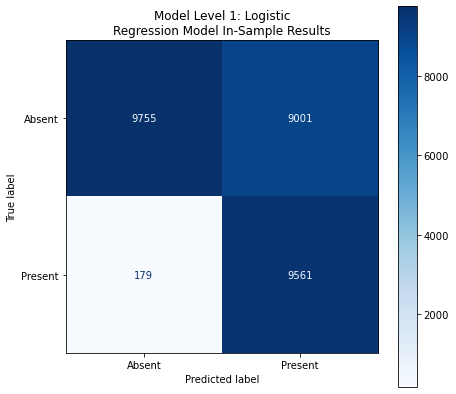

In [170]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X_test_scaled_labeled, y_test, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

From above, we see that the model is able to achieve an ok F1 score and accuracy. From the confusion matrix, we can see that our model seems to confuse absent points with present points aka false positives, as shown in the top right corner. There may be many reasons for this, and a great way of understanding what might be causing the model's high false positive rate is to visualise its performance over the training region. We do this by plotting a probabilty heatmap in the section below.


#### Probability Heatmap

To create the probability heatmap, we write a function called `plot_heatmap`. This function will take in the model predictions from the entire region as stored in the `resultant_image` variable, and visualise these probabilities as a heatmap. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the target species occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly. Particularly, we are interested in the high false positive rate.

In [155]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )
        non_target = frog_data.occurrenceStatus == 0
        axis.scatter(
            frog_data[non_target].decimalLongitude, frog_data[non_target].decimalLatitude, 
            color = 'yellow', marker='.', alpha=0.5, label='Off-Target Species' if i==0 else ''
        )
    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
#plot_heatmap(resultant_image, all_all_frogs, f"Logistic Regression Model Results - {region_name}")

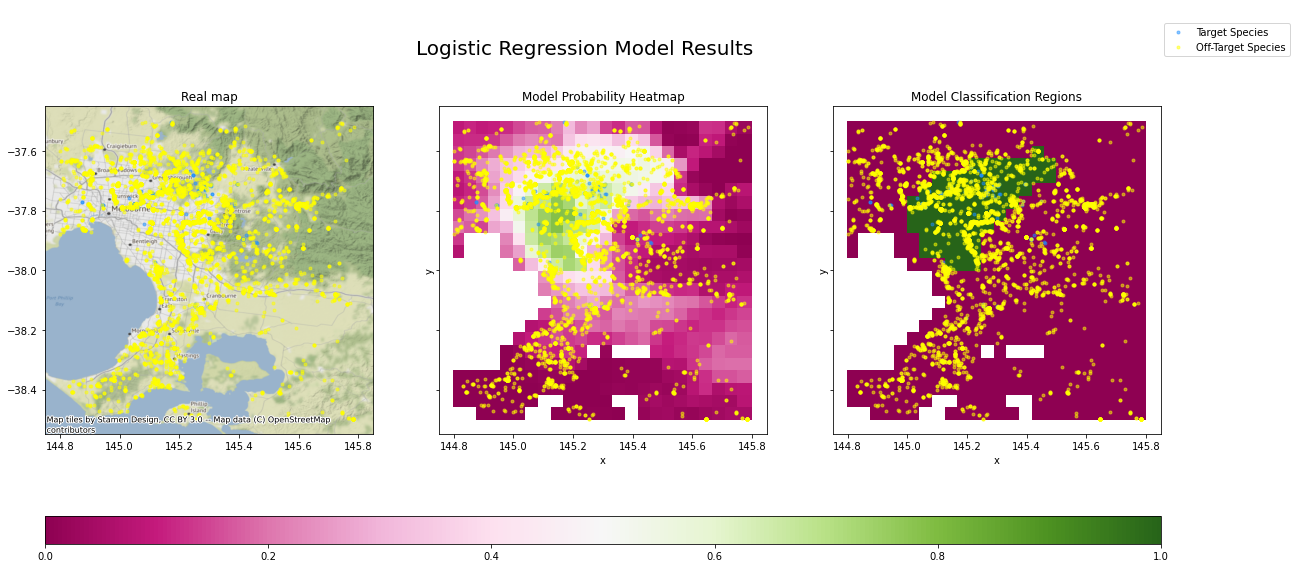

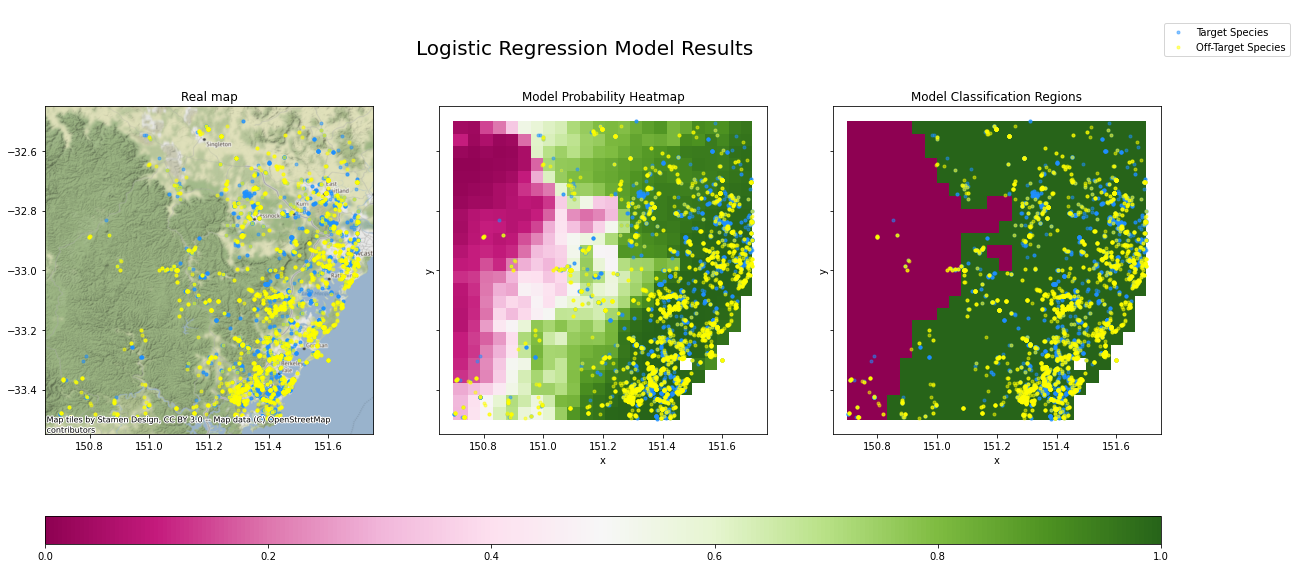

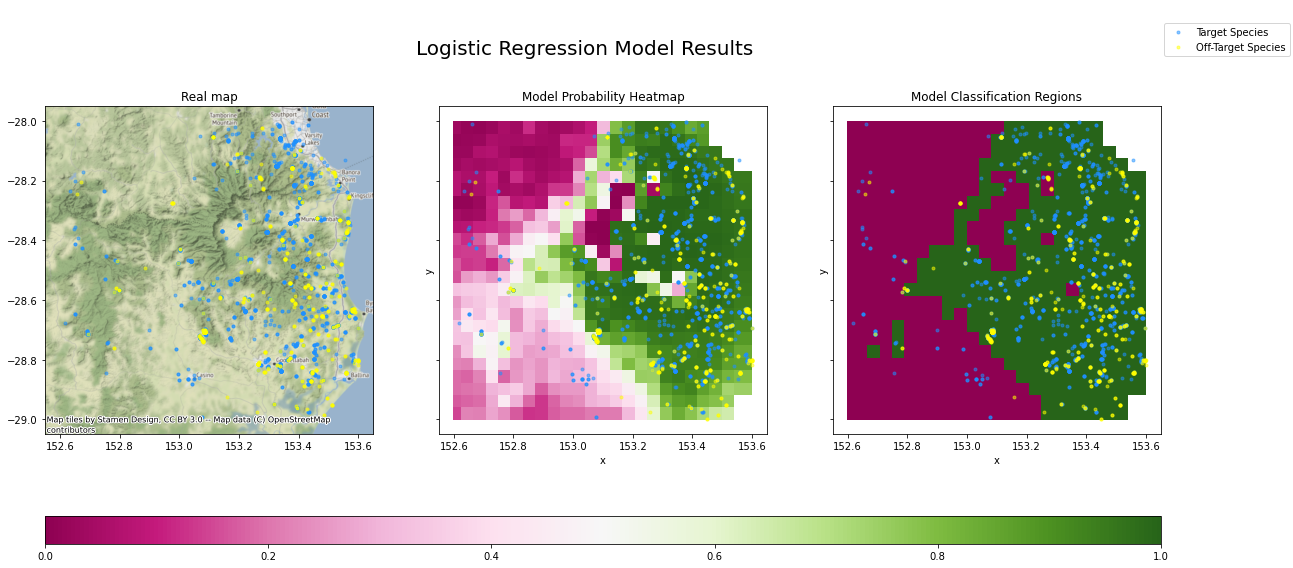

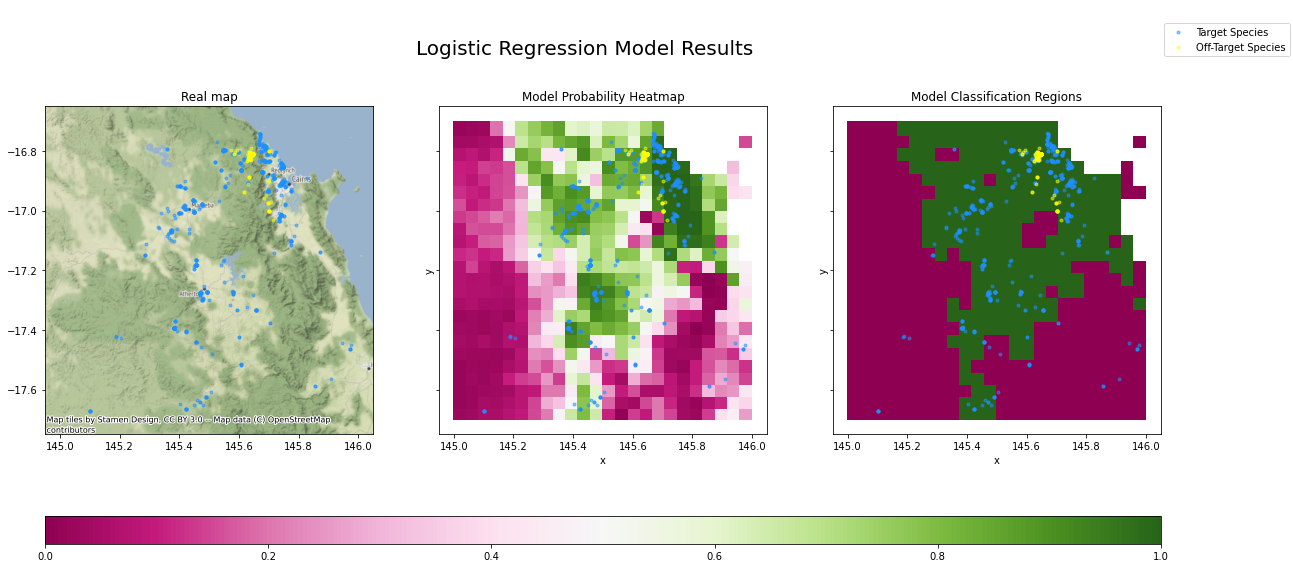

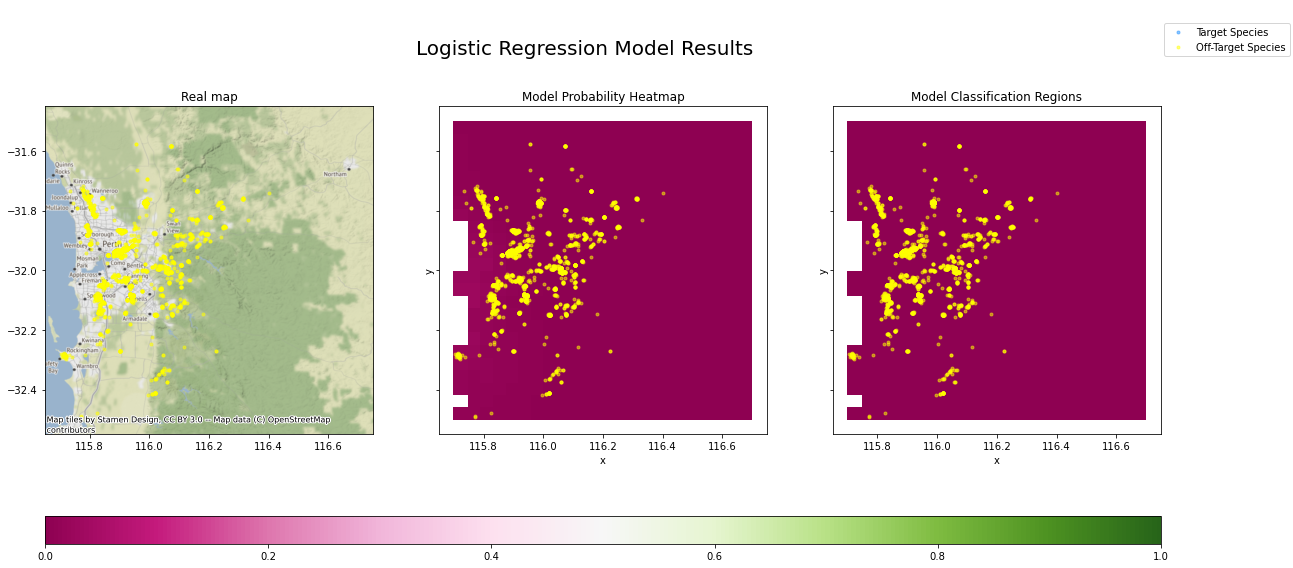

In [162]:
for weather_data in arrays:
    plot_heatmap(predict_frogs(weather_data, full_model), model_data_test, f"Logistic Regression Model Results")

From the plots above, we can see that the model does a pretty good job of mapping where litoria fallax is. However, our performance metrics before suggested otherwise. The main limitation of the evaluation metrics comes from the pseudo absence species, crinia signifera, sharing much of the same habitat as litoria fallax. This paired with the relatively coarse spatial resolution of TerraClimate makes distinguising close habitats difficult. This explains the high rate of false positives, as there are many frog absence points within the green classification region. 

There are many ways you might go about addressing this issue. Perhaps choosing a species that does not closely share the same habitat as litoria fallax. Alternatively, a greater variety of spatial sampling could also resolve this issue, i.e. picking extra regions where only litoria fallax exists and some where only other species exist. Another option is to abandon the pseudo-absence approach entirely and develop a unique way of sampling for absence points. Ultimately, you might think it is worthwhile improving the training set to make your evaluation metrics a little more representative of the SDM performance. 



In [157]:
def plot_heatmap_w_thresh(resultant_image, frog_data, title, thresholds, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    for i, threshold in enumerate(thresholds):
        ax[i].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
        cx.add_basemap(ax[i], crs=crs)
        regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>threshold).plot.imshow(
            x='x', y='y', ax=ax[i], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
        ax[i].set_aspect('equal')
        ax[i].set_title('Model Classification Regions')

    # Plot binary classification from model


    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )
        non_target = frog_data.occurrenceStatus == 0
        axis.scatter(
            frog_data[non_target].decimalLongitude, frog_data[non_target].decimalLatitude, 
            color = 'yellow', marker='.', alpha=0.5, label='Off-Target Species' if i==0 else ''
        )
    #fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)

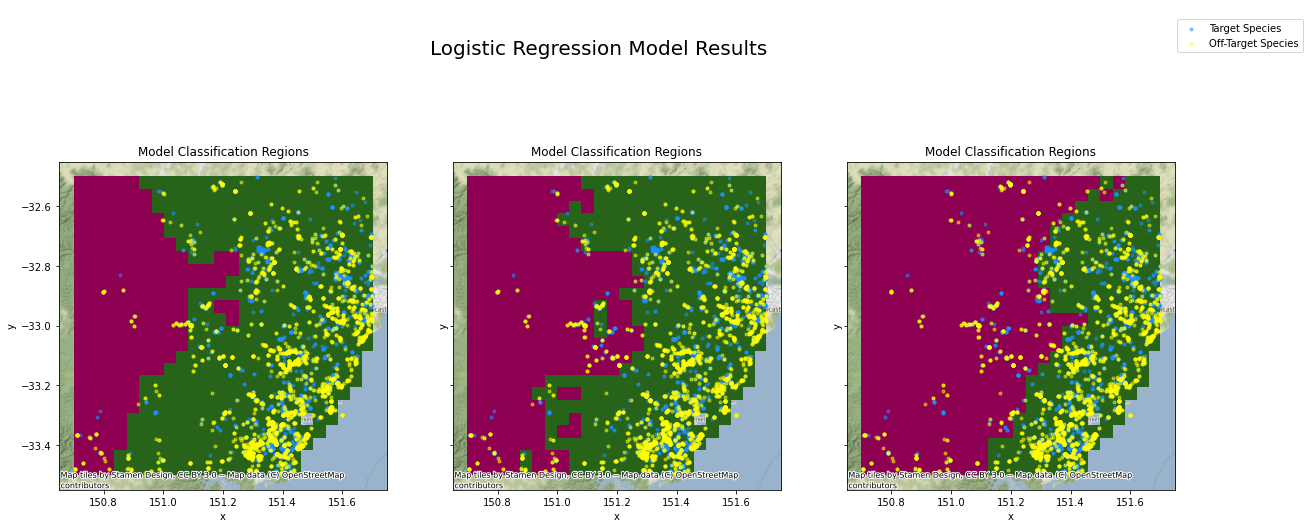

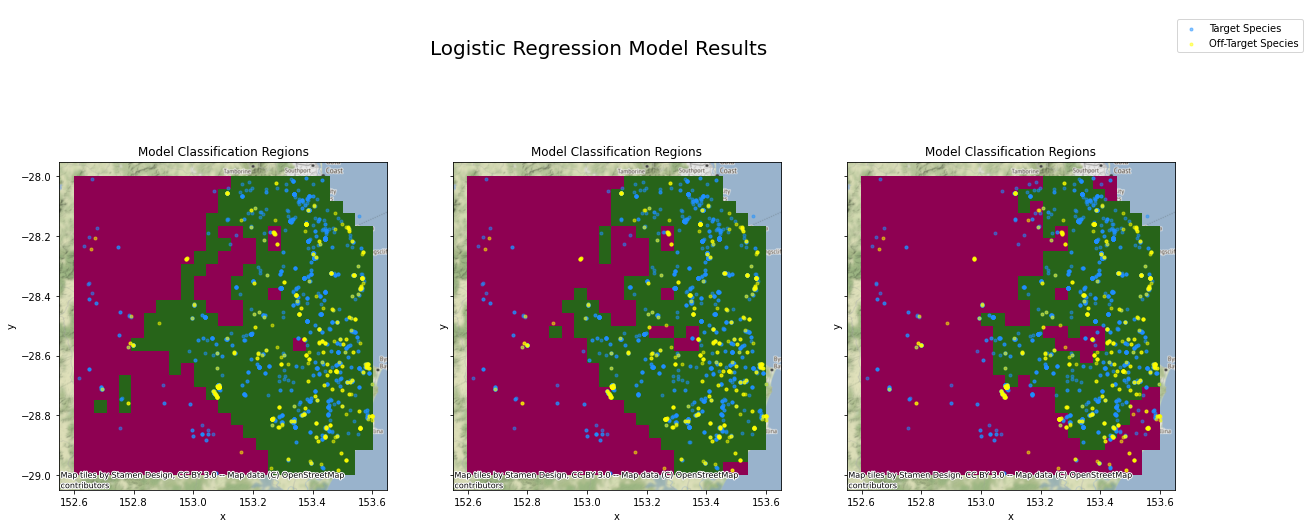

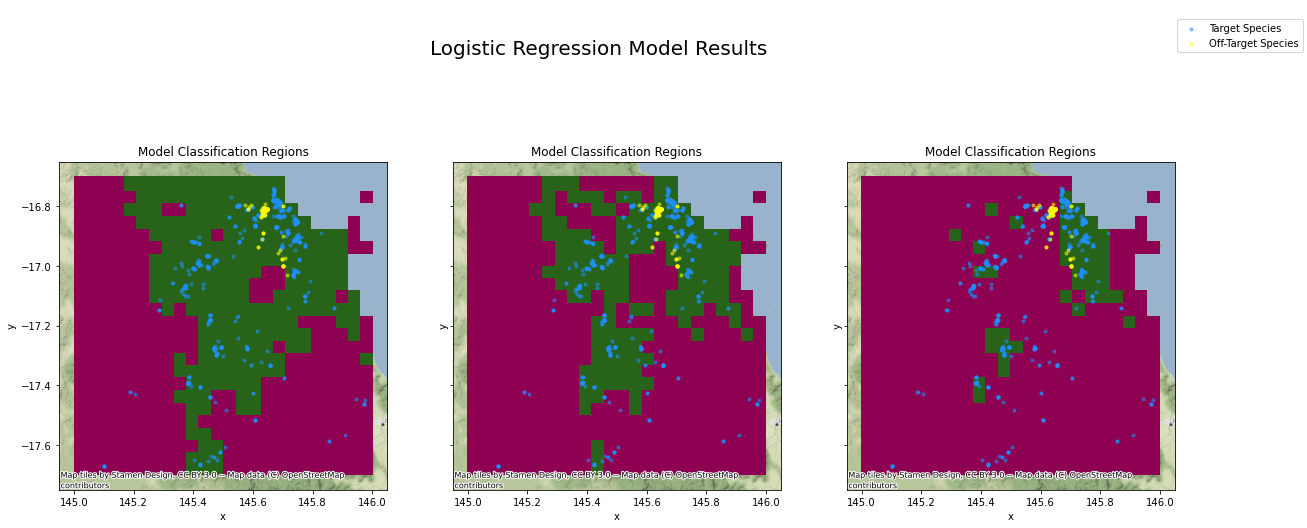

In [163]:
thresholds = [0.5, 0.7, 0.9]
for weather_data in arrays[1:4]:
    plot_heatmap_w_thresh(predict_frogs(weather_data, full_model), model_data_test, f"Logistic Regression Model Results",thresholds)

In [ ]:
thresholds = [0.5, 0.6, 0.7]
for weather_data in arrays[1:4]:
    plot_heatmap_w_thresh(predict_frogs(weather_data, clf), all_all_frogs, f"Logistic Regression Model Results",thresholds)

#### Out-of-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

Scikit-learn has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.

Again, these metrics are derived from a biased sample, so be careful what you infer.


The results from the 10-fold cross validation are similar than the in-sample metrics. This is a good sign as it shows that we haven't overfit our model. We see similar behavour in the higher rate of false positives that we saw in the in-sample performance. 

## Submission

Once you are happy with your model, there will come a time to make a submission to the challenge. To make a submission, you will need to use your model to make predictions about the presence of litoria fallax for a set of test coordinates we have provided. The coordinates are found in the 'challenge_1_submission_template.csv' file, and the list of bounding boxes where the points were sampled from can be found separately in the 'challenge_1_test_regions.txt' file. We recommend looping through the regions identified in that file, pulling the TerraClimate data for that region, and extracting the features for each point in the 'test_1_occurrences.csv' file within that regions bounding box. This will minimise the computational requirements.

In [171]:
# Load in test coordinates
test_file = pd.read_csv('challenge_1_submission_template.csv')

In [172]:
# Read in test regions
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [173]:
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

Note: with the TerraClimate parameters we have set, some areas of each region contain nulls. If this is the case, the prediction will return a null, which evaluates to false when we create the binary mask.

Loading data
Calculating mean
Calculating min
Calculating max
Calculating std


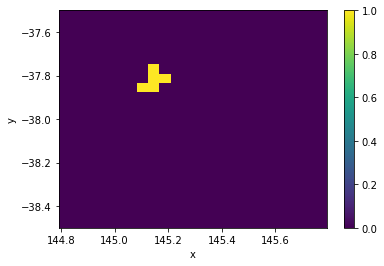

Loading data
Calculating mean
Calculating min
Calculating max
Calculating std


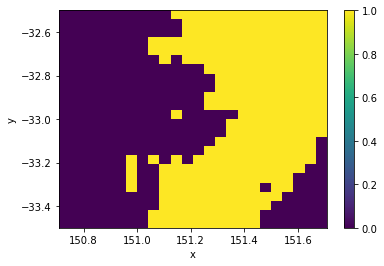

Loading data
Calculating mean
Calculating min
Calculating max
Calculating std


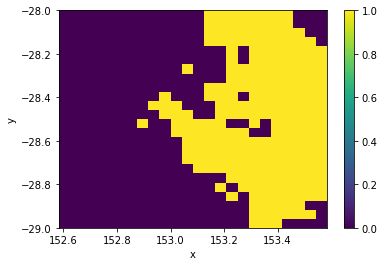

Loading data
Calculating mean
Calculating min
Calculating max
Calculating std


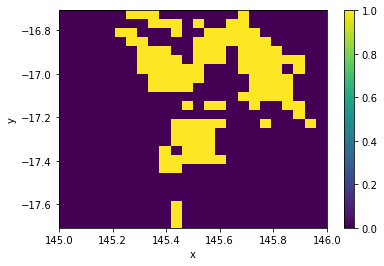

Loading data
Calculating mean
Calculating min
Calculating max
Calculating std


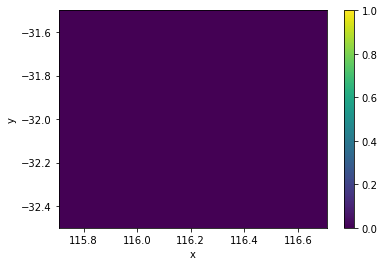

In [174]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.75
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    

In [ ]:
clf.score(X_test_scaled_labeled, y_test)

We can now use these classification regions to assign predictions for each of the coordinates specified in the test file. We do this in a similar way to the `join_frogs` function we defined earlier, except in this case we are joining a prediction to each coordinate.


In [175]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)


What we are left with is a submission file with three columns: decimalLatitude, decimalLongitude, and occurrenceStatus. This is the file you will submit to the EY Data Science Challenge platform to receive your score on the leaderboard.

In [176]:
display(submission)

# Save to output folder
submission.to_csv('all_BB_background_Frogs_robs_metrics_CLF.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,0
1,1,-37.770833,144.979167,0
2,2,-37.979167,145.354167,0
3,3,-37.604167,145.020833,0
4,4,-38.479167,145.645833,0
...,...,...,...,...
4046,4046,-31.895833,116.145833,0
4047,4047,-32.395833,115.770833,0
4048,4048,-32.145833,115.854167,0
4049,4049,-31.812500,116.229167,0


In [ ]:
all_all_frogs

### Get Frogging!

Now that you have witnessed a basic approach to model training, its time to try your own approach! Feel free to modify any of the functions presented in this notebook. A good start might be to try running this notebook on a region different to Greater Sydney, or even on multiple regions.

Be sure to address some of the assumptions made here, particularly ways to address the sampling bias in the dataset. Our pseudo-absence method was just one idea, you may want to persue another. Another important issue to consider is that of class imbalance. In this notebook, we simply down-sampled the non-target species to match the number of target species. This may not be ideal, as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. Perhaps a method of sampling only from clustered occurrences would address class imbalance while also helping to offset the sampling bias. Just a thought! You might even decide on a completely different training set, such as classifying regions rather than points. Do whatever you think will create the best model for predicting the frog habitat of the species of interest. Happy frogging!

In [ ]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    ### modification to add noise #### 
    added_bands = ['noisey']
    originial_data = region['predictors']
    
    dims = originial_data.dims
    ycoords = originial_data.y
    xcoords = originial_data.x
    combined_bands = list(originial_data.band.values)

    for i in range(len(added_bands)):
        combined_bands.append(added_bands[i])
    combined_bands = np.array(combined_bands)
    originial_band_number = originial_data.values.shape[0]
    originial_data_band_shape =originial_data.values.shape[1:]
    new_values = np.zeros([originial_band_number+len(added_bands), originial_data.values.shape[1], originial_data.values.shape[2]])
    new_values[0:originial_band_number] = originial_data.values
    new_values[originial_band_number:originial_band_number+len(added_bands)] = np.random.randn(*originial_data_band_shape)*100
    
    modified_data = xr.DataArray(
    data=new_values,
    dims=dims,
    coords=dict(
        band=combined_bands,
        y=ycoords,
        x=xcoords)
    )
    
    region['result'] = predict_frogs(modified_data, full_model) > 0.5
    ### modification to add noise ### 
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    